# Simulations for the Acetate Flux Branching

In [22]:
import pandas as pd
import numpy as np
# import re
import os
from datetime import date

# loading matplotlib, a library for visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# loading cobrapy, a library dedicated to the analysis of genome scale metabolic models
from cobra.io import read_sbml_model, write_sbml_model, save_matlab_model, save_json_model
from cobra import Reaction
from cobra.flux_analysis import geometric_fba, pfba

Today = date.today().strftime('%y%m%d')
FigureType = 'svg'

## Defining support functions for analysis of GSMM iUma22v1.1

In [32]:
def SimCosub(model, Exchange_dic, Objective=None):
    '''
    Simulating a model with multiple substrates

    Arguments:
    model: cobra model, iUma22
    Exchange_dic: dictionary, exchange reaction ID as keys and flux as values
    Objective (optional): string, reaction to be optimized

    Return:
    Flux table from model.optimize
    '''
    with model as model:
        model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
        [setattr(model.reactions.get_by_id(key), 'lower_bound', -value) for key, value in Exchange_dic.items()]
        if Objective:
            model.objective = Objective # 'EX_itacon_e'
        # Flux = model.optimize().fluxes
        Flux = pfba(model)
    #     print('glc actual:{}, ace actual:{}'.format(mySol[-1]['EX_glc__D_e'], mySol[-1]['EX_ac_e']))
    #     print('Simulated total C-Flux: ',6*mySol[-1]['EX_glc__D_e'] + 2*mySol[-1]['EX_ac_e'])
    # #     print(glc_up, ace_up)
    return Flux
    
RctFluxName = {'HEX1':6, 
         'G6PDH':6, 
         'MDH':4, 
         'THRALD':4,
         'TRANS-RXNTFS-7-ACET1018':2, 
         'CSNATr':2, 
         'ACONTa':6, 
         'ISOCIT-CLEAV-RXN':6, 
         'MALSm':4, 
         'SUCDH_q6_m':4, 
         'MDHm':4,
         'TRANS_Malate_Phosphate_Shuttle':4, 
         'TRANS_Cis_Aconitate_Malate_Shuttle':4, 
         'Putative_Trans_Aconitate_Decarboxylase':1, 
         'EX_co2_e':1,
         'EX_itacon_e':5}

## Loading iUma22v1.1 model

In [24]:
# generating cobra variable from SBML/xml file
# assuming the base path is in 'model' of a cloned git-directory of iUma22.
ModelDir = os.path.join('..','model')
ModelFile = 'iUma22v1.1.xml'
iUmaFile = os.path.join(ModelDir,ModelFile)
model = read_sbml_model(iUmaFile)

## Simulations of co-substrate uptake
### Optimization to maximum growth

In [37]:
MaxGrowth = 60
CFlux = 13.2
# Acetate comes first, then glucose
SubFlux = [[ratio*CFlux/(2*100),(CFlux-ratio*CFlux/100)/6] for ratio in range(MaxGrowth+1)]
EXID = ['EX_ac_e','EX_glc__D_e']
myGrowth = list()

for Feed in SubFlux:
    ExchDict = {EXID[i]:Feed[i] for i in range(len(EXID))}
    Flux = SimCosub(model, ExchDict)

    Ctot = np.abs(6*Flux['EX_glc__D_e'] + 2*Flux['EX_ac_e'])
    glc = np.abs(6*Flux['EX_glc__D_e'])
    ace = np.abs(2*Flux['EX_ac_e'])
    AcTot = ace/Ctot
    bio = np.abs(Flux['BIOMASS_REACTION'])
    Resi = {'C-Flux': Ctot, 'Glc':glc, 'Ace':ace, 'AceRel': AcTot, 'Growth':bio} 
    myGrowth.append(Resi.copy())

gres_df = pd.DataFrame(myGrowth)
gres_df['AceProc'] = gres_df['AceRel']*100

### Plot Growth VS Acetate Carbon Ratio

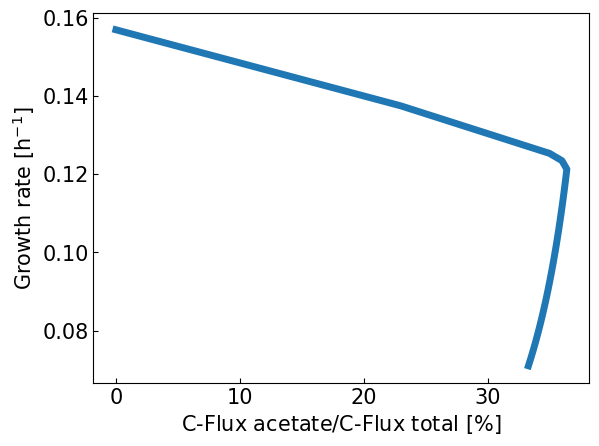

In [38]:
FigureName = 'AceRel-VS-Growth'

RatioNumb = [0,40,62]#[22,32,43]
DataDiv = [np.arange(0,RatioNumb[0]),np.arange(RatioNumb[0],RatioNumb[1])]
matplotlib.rcParams.update({'font.size': 15})
# ticks inside:
# https://stackoverflow.com/questions/47873389/matplotlib-move-tick-labels-inside-plot-area

gres_df.plot('AceProc', 'Growth', legend=None, lw=5) #, marker='o', markerfacecolor='black', ms=7
plt.xlabel('C-Flux acetate/C-Flux total [$\%$]')
plt.ylabel('Growth rate [h$^{-1}$]')
plt.tick_params(direction="in")
# plt.savefig('{}_{}.{}'.format(Today,FigureName,FigureType))

plt.show()

### Optimization to Ita

In [39]:
MaxGrowth = 60
CFlux = 13.2
# Acetate comes first, then glucose
SubFlux = [[ratio*CFlux/(2*100),(CFlux-ratio*CFlux/100)/6] for ratio in range(MaxGrowth+1)]
EXID = ['EX_ac_e','EX_glc__D_e']
myGrowth = list()

for Feed in SubFlux:
    ExchDict = {EXID[i]:Feed[i] for i in range(len(EXID))}
    Flux = SimCosub(model, ExchDict, 'EX_itacon_e')

    Ctot = np.abs(6*Flux['EX_glc__D_e'] + 2*Flux['EX_ac_e'])
    glc = np.abs(6*Flux['EX_glc__D_e'])
    ace = np.abs(2*Flux['EX_ac_e'])
    AcTot = ace/Ctot
    ita = np.abs(5*Flux['EX_itacon_e'])
    iy = ita/Ctot
    bio = np.abs(Flux['BIOMASS_REACTION'])
    Resi = {'C-Flux': Ctot, 'Glc':glc, 'Ace':ace, 'AceRel': AcTot, 'Growth':bio, 'Ita':ita, 'Ita C-Yield':iy} 
    myGrowth.append(Resi.copy())

gres_df = pd.DataFrame(myGrowth)
gres_df['AceProc'] = gres_df['AceRel']*100

### Plot Ita VS Acetate Carbon Ratio

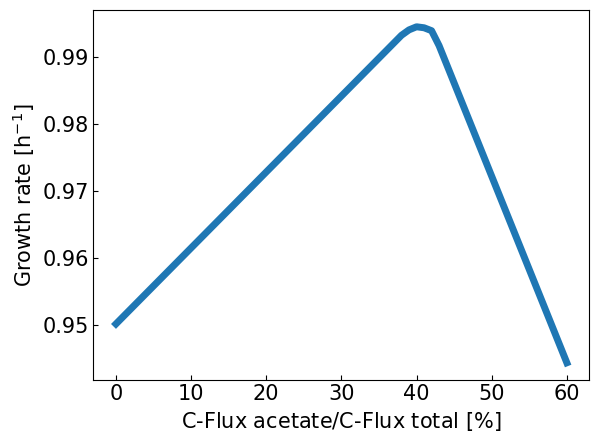

In [40]:
FigureName = 'AceRel-VS-Growth'

RatioNumb = [0,40,62]#[22,32,43]
DataDiv = [np.arange(0,RatioNumb[0]),np.arange(RatioNumb[0],RatioNumb[1])]
matplotlib.rcParams.update({'font.size': 15})
# ticks inside:
# https://stackoverflow.com/questions/47873389/matplotlib-move-tick-labels-inside-plot-area

gres_df.plot('AceProc', 'Ita C-Yield', legend=None, lw=5)
plt.xlabel('C-Flux acetate/C-Flux total [$\%$]')
plt.ylabel('Growth rate [h$^{-1}$]')
plt.tick_params(direction="in")
plt.savefig('{}_{}.{}'.format(Today,FigureName,FigureType))

plt.show()

## Mutant simulations

In [16]:
KO = ['HISTD', 'MDH', 'TRANS_Adenine_Nucleotide_Transporter'] # , 'MDH', 'TRANS_Adenine_Nucleotide_Transporter'
[print(model.reactions.get_by_id(myKO).reaction) for myKO in KO]
GlcFlux = 38/6
AceFlux = 62/2
with model as model:
    model.reactions.get_by_id('EX_glc__D_e').lower_bound = -GlcFlux
    model.reactions.get_by_id('EX_ac_e').lower_bound = -AceFlux
    [setattr(model.reactions.get_by_id(myKO), 'bounds',[0,0]) for myKO in KO]
    # model.objective = 'EX_itacon_e'
    KOSol = model.optimize()
Ctot = 6*KOSol.fluxes['EX_glc__D_e']+2*KOSol.fluxes['EX_ac_e']
exp4all = KOSol.fluxes/np.abs(Ctot)*100
print('#################################################################################')
# print(f'Normalized 100 C-flux for ratio index {ratio}')
[print(f'{model.reactions.get_by_id(Rct).id} \t {model.reactions.get_by_id(Rct).reaction} \t {round(exp4all[Rct]*Ccount)}') for Rct,Ccount in RctFluxName.items()];

h2o_c + histd_c + 2.0 nad_c --> 3.0 h_c + his__L_c + 2.0 nadh_c
mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
adp_c + atp_m --> adp_m + atp_c
#################################################################################
HEX1 	 atp_c + glc__D_c --> adp_c + g6p_c + h_c 	 99
G6PDH 	 g6p_c + nadp_c --> 6pgl_c + h_c + nadph_c 	 1
MDH 	 mal__L_c + nad_c <=> h_c + nadh_c + oaa_c 	 0
THRALD 	 thr__L_c --> acald_c + gly_c 	 0
TRANS-RXNTFS-7-ACET1018 	 ac_e --> ac_c 	 0
CSNATr 	 acrn_m + coa_m --> accoa_m + crn_m 	 2
ACONTa 	 cit_m <=> acon_C_m + h2o_m 	 6
ISOCIT-CLEAV-RXN 	 icit_m --> glx_m + succ_m 	 0
MALSm 	 accoa_m + glx_m + h2o_m --> coa_m + h_m + mal__L_m 	 0
SUCDH_q6_m 	 q6_m + succ_m --> fum_m + q6h2_m 	 3
MDHm 	 mal__L_m + nad_m <=> h_m + nadh_m + oaa_m 	 3
TRANS_Malate_Phosphate_Shuttle 	 mal__L_c + pi_m <=> mal__L_m + pi_c 	 -3
TRANS_Cis_Aconitate_Malate_Shuttle 	 acon_C_m + mal__L_c <=> acon_C_c + mal__L_m 	 0
Putative_Trans_Aconitate_Decarboxylase 	 acon_T_c + h_c --> co2_c + itaco